# Transfer Learning with MobileNet: Core Concepts Guide  

#### Steps to Building a Custom Classifier

1. **Data Collection**  
   Split into training and validation sets.

2. **Data Pipeline Creation**  
   Involves reading data, preprocessing, and grouping where necessary.

3. **Data Augmentation** *(Optional)*  
   Apply if the dataset is small; otherwise, skip.

4. **Define the Model** *(If using pretrained models)*  
   - Remove the last task-specific layers  
   - Append your new classifier head  
   - Freeze the weights of the original layers  
   - Select an optimization algorithm  
   - Define performance evaluation metric(s)

5. **Train and Test**  
   Train the model and evaluate on the validation/test set.

---

## 1. Transfer Learning – The Smart Shortcut

**Definition**:  
Take a model already trained on a massive dataset (like **ImageNet**) and *repurpose* it for your own task.

### Why It Works
| Benefit | Explanation |
|--------|-------------|
| **Less Training Time** | Most of the hard work (learning edges, shapes, textures) is already done |
| **Less Data Needed** | You don’t need 1M+ images — even 100 per class can work |
| **Better Accuracy** | Pre-learned features are robust and general-purpose |

> **Think of it like this**:  
> Instead of teaching a child to draw from scratch, give them a coloring book with outlines already drawn.

---

## 2. Why MobileNet? – Built for the Real World

MobileNet is a **lightweight CNN** designed for devices with constraints.

| Ideal When | Reason |
|----------|--------|
| Running on phones, IoT, or edge devices | Tiny model size (4–16 MB) |
| Need fast predictions (<100ms) | Optimized for low latency |
| Limited CPU/GPU power | Efficient depthwise separable convolutions |
| Frequent model updates or downloads | Small file = fast deployment |

> **Rule of Thumb**:  
> If your app runs on a smartphone and needs real-time inference — **MobileNet is the default choice**.

---

## 3. The Architecture Pattern – Layer by Layer

A clear, repeatable flow for transfer learning:

```text
[Input Image]
      ↓
[Pre-trained MobileNet] → Frozen Feature Extractor
      ↓
[Global Average Pooling] → Summarizes feature maps
      ↓
[Dense Layer(s)] → Learns your specific classes
      ↓
[Dropout] → Prevents memorizing the training data
      ↓
[Output Layer – Softmax] → Gives class probabilities

#### i) Data Collection/Organization

In [1]:
"""from pathlib import Path
import shutil
import random

# Define paths
source_path = Path("/home/vdv/Computer_Vision/dataset/training_set/training_set")
base_path = Path("/home/vdv/Computer_Vision/dataset")  # Base path up to dataset

# Create training and validation folders
training_path = base_path / "training"
validation_path = base_path / "validation"

training_path.mkdir(exist_ok=True)
validation_path.mkdir(exist_ok=True)

# Check for cats and dogs folders in source
cats_source = source_path / "cats"
dogs_source = source_path / "dogs"

# Process each category
for category_name, category_source in [("cats", cats_source), ("dogs", dogs_source)]:
    if category_source.exists() and category_source.is_dir():
        print(f"Processing {category_name}...")
        
        # Create category folders in training and validation
        train_category = training_path / category_name
        val_category = validation_path / category_name
        train_category.mkdir(exist_ok=True)
        val_category.mkdir(exist_ok=True)
        
        # Get all files from source category
        files = [f for f in category_source.iterdir() if f.is_file()]
        
        # Shuffle files for random split
        random.shuffle(files)
        
        # Calculate split point (80% training, 20% validation)
        split_point = int(len(files) * 0.8)
        
        train_files = files[:split_point]
        val_files = files[split_point:]
        
        # Move files to training folder
        for file in train_files:
            shutil.move(str(file), str(train_category / file.name))
        
        # Move files to validation folder
        for file in val_files:
            shutil.move(str(file), str(val_category / file.name))
        
        print(f"  ✓ {category_name}: {len(train_files)} files to training, {len(val_files)} files to validation")
    else:
        print(f"  ⚠ {category_name} folder not found at {category_source}")

print("\nFolder structure created:")
print(f"📁 {training_path}")
print(f"   📁 cats ({len(list((training_path / 'cats').glob('*'))) if (training_path / 'cats').exists() else 0} files)")
print(f"   📁 dogs ({len(list((training_path / 'dogs').glob('*'))) if (training_path / 'dogs').exists() else 0} files)")
print(f"📁 {validation_path}")
print(f"   📁 cats ({len(list((validation_path / 'cats').glob('*'))) if (validation_path / 'cats').exists() else 0} files)")
print(f"   📁 dogs ({len(list((validation_path / 'dogs').glob('*'))) if (validation_path / 'dogs').exists() else 0} files)")

print("\n⚠️  Note: Files have been MOVED from the original location!")"""

'from pathlib import Path\nimport shutil\nimport random\n\n# Define paths\nsource_path = Path("/home/vdv/Computer_Vision/dataset/training_set/training_set")\nbase_path = Path("/home/vdv/Computer_Vision/dataset")  # Base path up to dataset\n\n# Create training and validation folders\ntraining_path = base_path / "training"\nvalidation_path = base_path / "validation"\n\ntraining_path.mkdir(exist_ok=True)\nvalidation_path.mkdir(exist_ok=True)\n\n# Check for cats and dogs folders in source\ncats_source = source_path / "cats"\ndogs_source = source_path / "dogs"\n\n# Process each category\nfor category_name, category_source in [("cats", cats_source), ("dogs", dogs_source)]:\n    if category_source.exists() and category_source.is_dir():\n        print(f"Processing {category_name}...")\n\n        # Create category folders in training and validation\n        train_category = training_path / category_name\n        val_category = validation_path / category_name\n        train_category.mkdir(exist_

#### ii) Build the data pipeline


In [2]:
"""
Transfer Learning Image Classification Module using MobileNetV2

This module implements a transfer learning pipeline for image classification tasks
using TensorFlow/Keras and the MobileNetV2 architecture. It provides the necessary
imports for building, training, and fine-tuning a custom image classifier on top
of a pre-trained MobileNetV2 model.

Key Components:
--------------
- **TensorFlow Framework**: Core deep learning library for model building and training
- **Data Pipeline**: ImageDataGenerator for real-time data augmentation and batch loading
- **Model Architecture**: MobileNetV2 pre-trained on ImageNet for feature extraction
- **Custom Layers**: Dense, Dropout, and Pooling layers for task-specific classification

Dependencies:
------------
- tensorflow >= 2.0.0
- numpy (imported by tensorflow)
- PIL/Pillow (for image processing)
- Python >= 3.7

Architecture Overview:
---------------------
The module sets up a transfer learning architecture with:
1. MobileNetV2 base model (pre-trained feature extractor)
2. Global Average Pooling layer (dimension reduction)
3. Custom Dense layers with Dropout (task-specific classifier)
4. Output layer with softmax/sigmoid activation

Typical Usage:
-------------
    >>> # Import this module
    >>> from transfer_learning import *
    >>> 
    >>> # Create data generators
    >>> train_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
    >>> 
    >>> # Build transfer learning model
    >>> base_model = MobileNetV2(input_shape=(224, 224, 3), 
    ...                          include_top=False, 
    ...                          weights='imagenet')
    >>> 
    >>> # Add custom classification head
    >>> inputs = Input(shape=(224, 224, 3))
    >>> x = base_model(inputs, training=False)
    >>> x = GlobalAveragePooling2D()(x)
    >>> x = Dense(128, activation='relu')(x)
    >>> x = Dropout(0.5)(x)
    >>> outputs = Dense(num_classes, activation='softmax')(x)
    >>> 
    >>> model = Model(inputs, outputs)

Module Imports:
--------------
- **tensorflow**: Main deep learning framework
- **ImageDataGenerator**: Handles data augmentation and batch generation
- **Model**: Functional API for creating custom models
- **Input**: Defines input tensor specifications
- **Flatten**: Converts multi-dimensional tensors to 1D (alternative to GlobalAveragePooling2D)
- **Dense**: Fully connected layers for classification
- **Dropout**: Regularization to prevent overfitting
- **GlobalAveragePooling2D**: Spatial dimension reduction (preferred over Flatten for CNNs)
- **MobileNetV2**: Efficient CNN architecture optimized for mobile/edge devices
- **preprocess_input**: MobileNetV2-specific preprocessing function for input normalization
- **math**: Mathematical operations for batch size and step calculations

Performance Considerations:
--------------------------
- MobileNetV2 is 2x faster than MobileNetV1 with better accuracy
- Input images must be 224x224 pixels (or 96, 128, 160, 192 for smaller variants)
- Preprocessing normalizes pixel values to [-1, 1] range
- Model size: ~14MB (compared to ResNet50's ~98MB)
- Parameters: ~3.5M (88% fewer than VGG16)

Notes:
-----
- The #type: ignore comments suppress Pylance/mypy warnings in VS Code
- MobileNetV1 is deprecated; this module uses the improved MobileNetV2
- For production, consider using tf.data.Dataset instead of ImageDataGenerator
- Global Average Pooling is preferred over Flatten for reducing overfitting

Warnings:
--------
- Ensure GPU drivers are properly installed for accelerated training
- Large batch sizes may cause OOM errors on limited GPU memory
- Always use the model-specific preprocess_input function

Author: Julius Junior
Date: November 2025
Version: 1.0
License: MIT

References:
----------
- MobileNetV2 Paper: https://arxiv.org/abs/1801.04381
- TensorFlow Transfer Learning: https://www.tensorflow.org/tutorials/images/transfer_learning
- Keras Applications: https://keras.io/api/applications/
"""

import tensorflow as tf
import numpy as np

# Use tf.keras (this is correct!)
from tensorflow.keras.preprocessing.image import ImageDataGenerator                                 #type: ignore
from tensorflow.keras.models import Model                                                           #type: ignore
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, GlobalAveragePooling2D          #type: ignore

# Fix this line: mobilenet is deprecated
# from tf.keras.applications.mobilenet import MobileNet, preprocess_input
from tensorflow.keras.applications import MobileNetV2                                               #type: ignore
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input                             #type: ignore

import math

2025-11-14 10:03:38.684809: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-14 10:03:38.778803: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-14 10:03:40.923694: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


In [3]:
#Configurations and constants can be added here as needed
TRAIN_DATA_DIR = '/home/vdv/Computer_Vision/dataset/training/'
VALIDATION_DATA_DIR = '/home/vdv/Computer_Vision/dataset/validation/'
TRAIN_SAMPLES = 500
VALIDATION_SAMPLES = 500
NUM_CLASSES = 2
IMG_WIDTH, IMG_HEIGHT = 224, 224
BATCH_SIZE = 64

# Classification Approaches: Binary vs. Multiclass

We have **two classes: cats and dogs**. This seemingly simple problem can be approached in two fundamentally different ways:

---

## 1. Binary Classification  
*“Is this a cat? Yes or No.”*

- Frames the task as a **single yes/no decision**
- Output: **One probability score**
  - ≥ 0.5 → **Cat**
  - < 0.5 → **Dog**
- **Assumption**: The test data contains **only cats or dogs**
- **Limitation**: Fails in real-world open-set scenarios (e.g., input is a ball → still classified as dog)

> **Note**: Keras processes classes in **alphabetical order** → `cats` before `dogs`

---

## 2. Multiclass Classification  
*“What is this? Cat, dog, or something else?”*

- Predicts **one label from 2+ classes**
- Outputs **separate probability for each class**
- Final prediction = class with **highest probability**
- Even for **two classes**, treats them explicitly (e.g., `P(cat)`, `P(dog)`)
- **Advantage**:  
  - Scales naturally to 3, 10, or 100+ classes  
  - More robust and reusable in production

> **Best Practice**:  
> **Always prefer multiclass** — even for 2 classes — to build **flexible, future-proof models**

## Batch Size & Data Augmentation

---

### Batch Size
- **Definition**: Number of images processed together in one forward/backward pass.
- **Purpose**:  
  - Ensures **balanced class representation** per update  
  - Stabilizes training (reduces accuracy fluctuations)
- **Best Practices**:  
  - Use **powers of 2** (e.g., 32, 64, 128)  
  - Start with **64**  
  - Avoid sizes too large → **GPU out-of-memory crash**

---

### Data Augmentation
- **Problem**: Small datasets (e.g., 500 images) → **overfitting**  
  → Model memorizes training data, fails on new images
- **Solution**: Artificially expand data via transformations:
  - **Rotation** (±20°)
  - **Shift** (left/right, up/down)
  - **Zoom** (in/out)
- **Benefits**:  
  - Creates **near-infinite variations**  
  - Improves **real-world robustness** (off-center, tilted objects)
- **Tool**: `ImageDataGenerator` applies augmentations **on-the-fly**

In [4]:
"""
Configure data augmentation for training and validation pipelines.

Creates two ImageDataGenerator instances:
1. train_datagen: Applies augmentation (rotation, shifts, zoom) + MobileNetV2 preprocessing
2. val_datagen: Applies only MobileNetV2 preprocessing (no augmentation)

Augmentation helps prevent overfitting by creating variations of training images
in real-time, while validation data remains unmodified for consistent evaluation.

Args passed to training generator:
    - rotation_range: ±20° random rotation
    - width_shift_range: 20% horizontal shift
    - height_shift_range: 20% vertical shift  
    - zoom_range: 20% zoom in/out
    - preprocessing_function: MobileNetV2 normalization [-1, 1]
"""


train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
rotation_range=20,
width_shift_range=0.2,
height_shift_range=0.2,
zoom_range=0.2)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [5]:
# Create Data Generators
# ======================
# Generators load images in batches from directory structure (data_dir/class_name/images)
# Memory efficient: loads only current batch instead of entire dataset

train_generator = train_datagen.flow_from_directory(
    TRAIN_DATA_DIR,                      # Root directory path: 'data/train_data/'
    target_size=(IMG_WIDTH, IMG_HEIGHT), # Resize to (224, 224) for MobileNetV2
    batch_size=BATCH_SIZE,               # 64 images per batch
    shuffle=True,                        # Randomize order each epoch (better training)
    seed=12345,                          # Fixed seed for reproducible augmentation
    class_mode='categorical'             # One-hot encoded labels for multi-class
)  # Output: "Found 500 images belonging to 2 classes"

validation_generator = val_datagen.flow_from_directory(
    VALIDATION_DATA_DIR,                 # Root directory path: 'data/val_data/'
    target_size=(IMG_WIDTH, IMG_HEIGHT), # Same size as training (224, 224)
    batch_size=BATCH_SIZE,               # Same batch size for consistency
    shuffle=False,                       # No shuffle for reproducible validation
    class_mode='categorical'             # Same encoding as training
)  # Output: "Found 500 images belonging to 2 classes"

Found 6402 images belonging to 2 classes.
Found 1603 images belonging to 2 classes.


In [6]:
def model_maker():
    """
    Create a transfer learning model using pre-trained MobileNet.
    
    This function builds a custom image classifier by combining a pre-trained MobileNet
    base (trained on ImageNet with 1.2M images) with a new classification head tailored
    for our specific task. Transfer learning allows us to leverage features learned from
    millions of images without training from scratch.
    
    Architecture Flow:
    -----------------
    Input Image (224×224×3)
        ↓
    MobileNet Base (frozen)
        - Extracts features learned from ImageNet
        - Outputs: 7×7×1024 feature maps
        - All 88 layers frozen to preserve learned patterns
        ↓
    GlobalAveragePooling2D
        - Reduces each 7×7 feature map to single value
        - Output: 1024-dimensional feature vector
        - More efficient than Flatten, reduces overfitting
        ↓
    Dense Layer (64 neurons, ReLU)
        - Learns task-specific patterns from extracted features
        - ReLU adds non-linearity for complex decision boundaries
        ↓
    Dropout (50%)
        - Randomly disables neurons during training
        - Prevents overfitting on small datasets
        ↓
    Output Layer (NUM_CLASSES neurons, Softmax)
        - Produces probability distribution over classes
        - Example: [0.8, 0.2] = 80% cat, 20% dog
    
    Key Concepts for Beginners:
    ---------------------------
    - **include_top=False**: Removes MobileNet's original 1000-class classifier
    - **Freezing layers**: Prevents pre-trained weights from changing during training
    - **Feature extraction**: MobileNet identifies edges, shapes, textures automatically
    - **GlobalAveragePooling**: Better than Flatten for CNNs, maintains spatial info
    - **Dropout**: Only active during training, not during prediction
    - **Softmax**: Ensures output probabilities sum to 1.0
    
    Returns:
        tensorflow.keras.Model: Complete model with:
            - ~3.2M frozen parameters (MobileNet features)
            - ~66K trainable parameters (custom classifier)
            - Input shape: (224, 224, 3)
            - Output shape: (NUM_CLASSES,) with probabilities
    
    Usage:
        model = model_maker()
        model.compile(optimizer='adam', loss='categorical_crossentropy')
        model.fit(train_generator, epochs=10)
    """
    base_model = MobileNetV2(include_top=False, input_shape=(IMG_WIDTH,IMG_HEIGHT,3))
    
    for layer in base_model.layers[:]:
        layer.trainable = False
    
    input = Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3))
    custom_model = base_model(input)
    custom_model = GlobalAveragePooling2D()(custom_model)
    custom_model = Dense(64, activation='relu')(custom_model)
    custom_model = Dropout(0.5)(custom_model)
    predictions = Dense(NUM_CLASSES, activation='softmax')(custom_model)
    
    return Model(inputs=input, outputs=predictions)

In [7]:
"""
Model Training Configuration and Execution

Compiles and trains the transfer learning model with optimized parameters
for binary classification task.

Training Parameters:
- Loss: Categorical crossentropy for multi-class classification
- Optimizer: Adam with learning rate 0.001 (balanced speed vs stability)
- Metric: Accuracy for interpretable performance tracking
- Epochs: 10 full passes through training data
- Steps: Calculated based on dataset size / batch size

Note: Learning rate of 0.001 is standard for Adam - too high causes overshooting,
too low causes slow convergence. Adjust if loss oscillates or plateaus.
"""

# Create the transfer learning model
model = model_maker()

# Configure training parameters
model.compile(
    loss='categorical_crossentropy',     # Penalizes incorrect predictions (works with softmax)
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  # NEW - TF 2.x syntax  # Adam optimizer: adaptive learning with momentum
    metrics=['accuracy']                      # Track accuracy for human-readable performance
)

# Calculate training steps (ensures all samples are seen each epoch)
num_steps = math.ceil(float(TRAIN_SAMPLES) / BATCH_SIZE)  # 500/64 = 8 steps per epoch

# Train the model (fit to data)
model.fit(
    train_generator,                     # Augmented training data
    steps_per_epoch=num_steps,          # 8 batches complete one epoch
    epochs=10,                          # 10 full passes through entire dataset
    validation_data=validation_generator, # Non-augmented validation data
    validation_steps=num_steps          # Validate on all validation samples
)

# Expected output: Progressive improvement in train/val accuracy over 10 epochs
# Watch for: Gap between train/val accuracy (overfitting) or plateau (adjust learning rate)

2025-11-14 10:03:42.113578: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 29s 3s/step - accuracy: 0.7949 - loss: 0.4440 - val_accuracy: 0.9629 - val_loss: 0.0881
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 23s 3s/step - accuracy: 0.9551 - loss: 0.1405 - val_accuracy: 0.9766 - val_loss: 0.0513
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.9316 - loss: 0.1853 - val_accuracy: 0.9922 - val_loss: 0.0245
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.9434 - loss: 0.1716 - val_accuracy: 0.9824 - val_loss: 0.0425
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.9644 - loss: 0.1057 - val_accuracy: 0.9707 - val_loss: 0.0670
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.9785 - loss: 0.0839 - val_accuracy: 0.9707 - val_loss: 0.0623
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.9746 - loss: 0.0839 - val_accuracy: 0.9512 - val_loss: 0.0968
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.9727 - loss: 0.0855 - val_accuracy: 0.9844 - val_loss: 0.0343
Epoch 9/

In [ ]:
#Save the trained model
model.save('/home/vdv/Computer_Vision/Practice/models/transfer_learning_model.keras')

In [9]:
#Model Testing
from tensorflow.keras.models import load_model  #type: ignore

model = load_model('/home/vdv/Computer_Vision/Practice/models/transfer_learning_model.h5')

In [10]:
"""img_path = '../../sample_images/dog.jpg'
img = image.load_img(img_path, target_size=(224,224))
img_array = image.img_to_array(img)
expanded_img_array = np.expand_dims(img_array, axis=0)
preprocessed_img = preprocess_input(expanded_img_array) # Preprocess the image
prediction = model.predict(preprocessed_img)
print(prediction)
print(validation_generator.class_indices)
[[0.9967706]]
{'dog': 1, 'cat': 0}"""

"img_path = '../../sample_images/dog.jpg'\nimg = image.load_img(img_path, target_size=(224,224))\nimg_array = image.img_to_array(img)\nexpanded_img_array = np.expand_dims(img_array, axis=0)\npreprocessed_img = preprocess_input(expanded_img_array) # Preprocess the image\nprediction = model.predict(preprocessed_img)\nprint(prediction)\nprint(validation_generator.class_indices)\n[[0.9967706]]\n{'dog': 1, 'cat': 0}"

#### Analyzing Results


In [11]:
"""
Image preprocessing and validation pipeline configuration.

Sets dimensions for MobileNet input requirements and defines validation
data source for model evaluation.

Configuration:
    IMG_WIDTH, IMG_HEIGHT: Input dimensions (224x224) required by MobileNet
    VALIDATION_DATA_DIR: Path to validation dataset with class subdirectories
    VALIDATION_BATCH_SIZE: Number of images per batch during evaluation (64)
"""

# VARIABLES
IMG_WIDTH, IMG_HEIGHT = 224, 224
VALIDATION_DATA_DIR = '/home/vdv/Computer_Vision/dataset/validation/'
VALIDATION_BATCH_SIZE = 64

In [12]:
"""
Configure validation data pipeline for model evaluation.

Creates a data generator that loads validation images without augmentation,
applying only MobileNetV2 preprocessing. Maintains original order for
consistent ground truth comparison.

Pipeline:
    - Loads images from class subdirectories
    - Resizes to 224x224 and normalizes to [-1, 1]
    - Generates batches of 64 images with one-hot labels
    - Preserves order (shuffle=False) for accurate metric calculation
    
Output:
    validation_generator: Yields (images, labels) batches
    ground_truth: Array of true class indices for performance metrics
"""

# DATA GENERATORS
validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input)
validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DATA_DIR,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=VALIDATION_BATCH_SIZE,
    shuffle=False,
    class_mode='categorical')
ground_truth = validation_generator.classes

Found 1603 images belonging to 2 classes.


In [14]:
#Prediction
predictions = model.predict(validation_generator)

26/26 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step


In [15]:
"""
Build prediction results table for model evaluation.

Creates a dictionary mapping each validation image to its prediction details,
enabling analysis of model confidence and errors.

Structure:
    prediction_table[image_index] = [confidence, predicted_class, true_class]
    - confidence: Highest probability score (0-1)
    - predicted_class: Class index with highest probability
    - true_class: Actual class index from ground truth

Assertion ensures all arrays have consistent length for valid comparison.
"""

# prediction_table is a dict with index, prediction, ground truth
prediction_table = {}
for index, val in enumerate(predictions):
    # get argmax index
    index_of_highest_probability = np.argmax(val)
    value_of_highest_probability = val[index_of_highest_probability]
    prediction_table[index] = [value_of_highest_probability,
                              index_of_highest_probability, ground_truth[index]]
assert len(predictions) == len(ground_truth) == len(prediction_table)

In [16]:
"""
Fix for undefined variables: fnames and plot_images function.

fnames: List of filenames from validation generator
plot_images: Function to visualize images in a grid with scores
"""

# FIX 1: Define fnames from validation generator
fnames = validation_generator.filenames  # Get all file paths relative to VALIDATION_DATA_DIR

# FIX 2: Define plot_images function
import matplotlib.pyplot as plt
from PIL import Image

def plot_images(image_paths, scores, title, rows=2, cols=5):
    """
    Display images in a grid with their associated scores.
    
    Args:
        image_paths: List of paths to images
        scores: List of confidence scores for each image
        title: Title for the entire plot
        rows, cols: Grid dimensions (default 2x5 for 10 images)
    """
    fig, axes = plt.subplots(rows, cols, figsize=(15, 6))
    axes = axes.ravel()
    
    for i, (img_path, score) in enumerate(zip(image_paths[:rows*cols], scores[:rows*cols])):
        img = Image.open(img_path)
        axes[i].imshow(img)
        axes[i].set_title(f'Conf: {score:.3f}')
        axes[i].axis('off')
    
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# FIX 3: Update display function with correct path construction
def display(sorted_indices, message):
    """
    Visualize sorted predictions with confidence scores.
    
    Args:
        sorted_indices: Sorted list of (index, [confidence, pred_class, true_class])
        message: Plot title describing the sorting criteria
    """
    similar_image_paths = []
    distances = []
    for name, value in sorted_indices:
        [probability, predicted_index, gt] = value
        # Fix: fnames already includes subdirectory, just prepend base path
        similar_image_paths.append(VALIDATION_DATA_DIR + fnames[name])
        distances.append(probability)
    plot_images(similar_image_paths, distances, message)

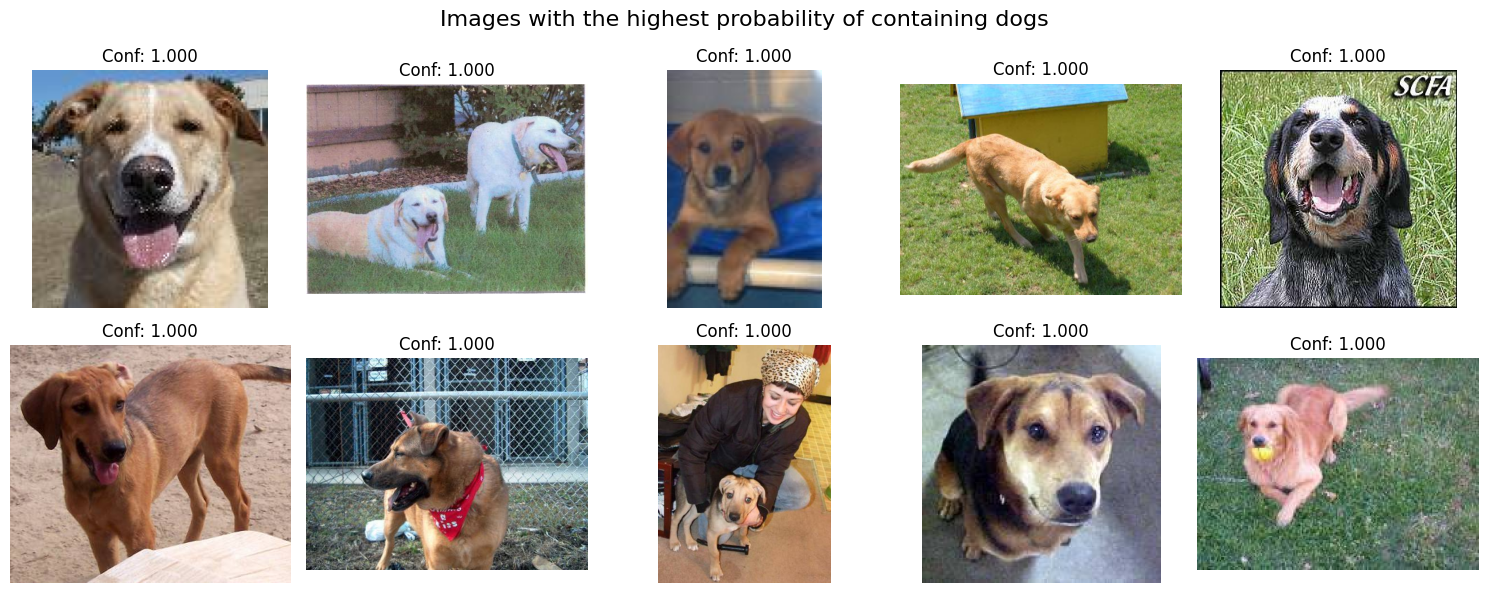

In [17]:
def get_images_with_sorted_probabilities(prediction_table, get_highest_probability=True, 
                                        label=0, number_of_items=10, 
                                        only_false_predictions=False):
    """
    Filter and sort predictions based on specified criteria.
    
    Args:
        prediction_table: Dict of {index: [confidence, predicted_class, true_class]}
        get_highest_probability: True for descending, False for ascending sort
        label: Target class to filter (0=cats, 1=dogs)
        number_of_items: Maximum results to return
        only_false_predictions: If True, only return misclassified images
    
    Returns:
        List of (index, prediction_info) tuples sorted by confidence
    """
    filtered_predictions = []
    
    for index, values in prediction_table.items():
        confidence, predicted_class, true_class = values
        
        # Filter by predicted label
        if predicted_class != label:
            continue
            
        # Filter by correctness if requested
        if only_false_predictions and predicted_class == true_class:
            continue
        if not only_false_predictions or predicted_class != true_class:
            filtered_predictions.append((index, values))
    
    # Sort by confidence
    sorted_predictions = sorted(filtered_predictions, 
                               key=lambda x: x[1][0], 
                               reverse=get_highest_probability)
    
    return sorted_predictions[:number_of_items]

# Now use it to display most confident dog predictions
indices = get_images_with_sorted_probabilities(prediction_table,
                                              get_highest_probability=True, 
                                              label=1,  # Dogs
                                              number_of_items=10,
                                              only_false_predictions=False)
message = 'Images with the highest probability of containing dogs'
display(indices[:10], message)

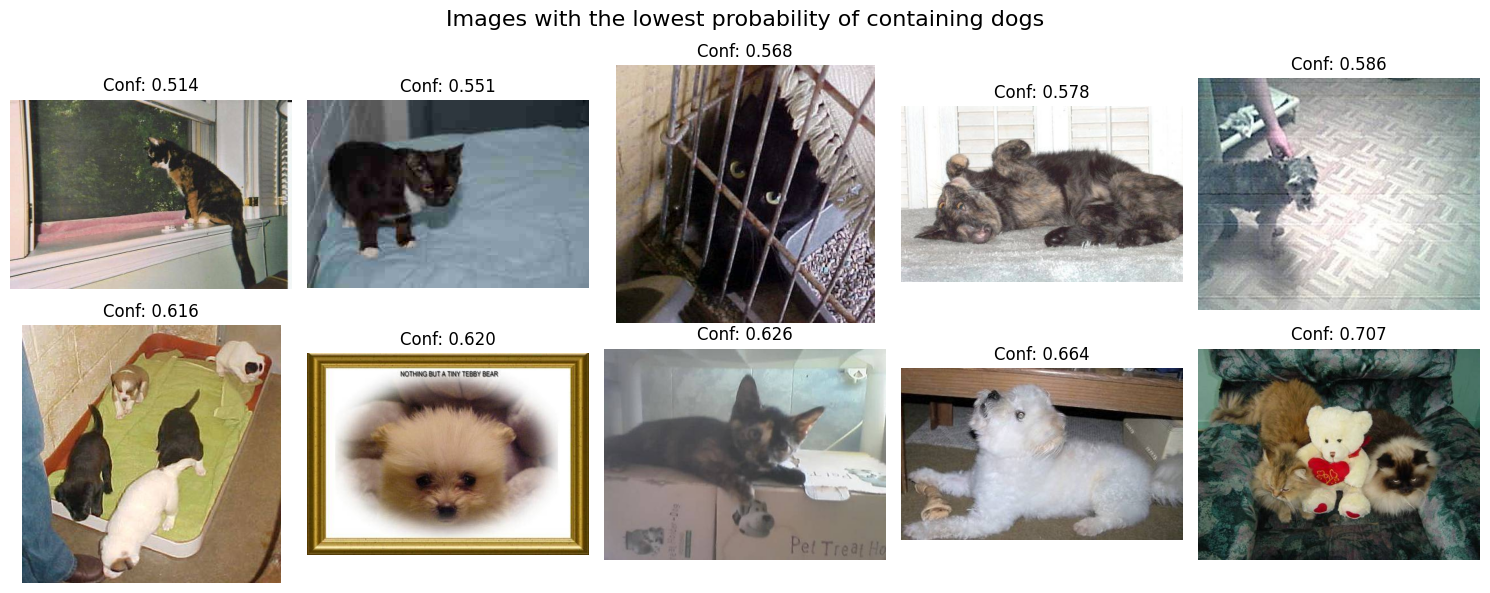

In [18]:
"""
Display the model's least confident dog predictions.

Retrieves and visualizes the 10 validation images that the model predicted
as 'dog' with the lowest confidence scores, helping identify edge cases
where the model is uncertain about its dog classification.

Parameters used:
    get_highest_probability=False: Sort by confidence ascending
    label=1: Dog class (assuming dogs=1, cats=0)
    number_of_items=10: Retrieve bottom 10 predictions
    only_false_predictions=False: Include both correct and incorrect predictions
"""

# Least confident predictions of 'dog'
indices = get_images_with_sorted_probabilities(prediction_table,
                                              get_highest_probability=False, label=1, number_of_items=10,
                                              only_false_predictions=False)
message = 'Images with the lowest probability of containing dogs'
display(indices[:10], message)

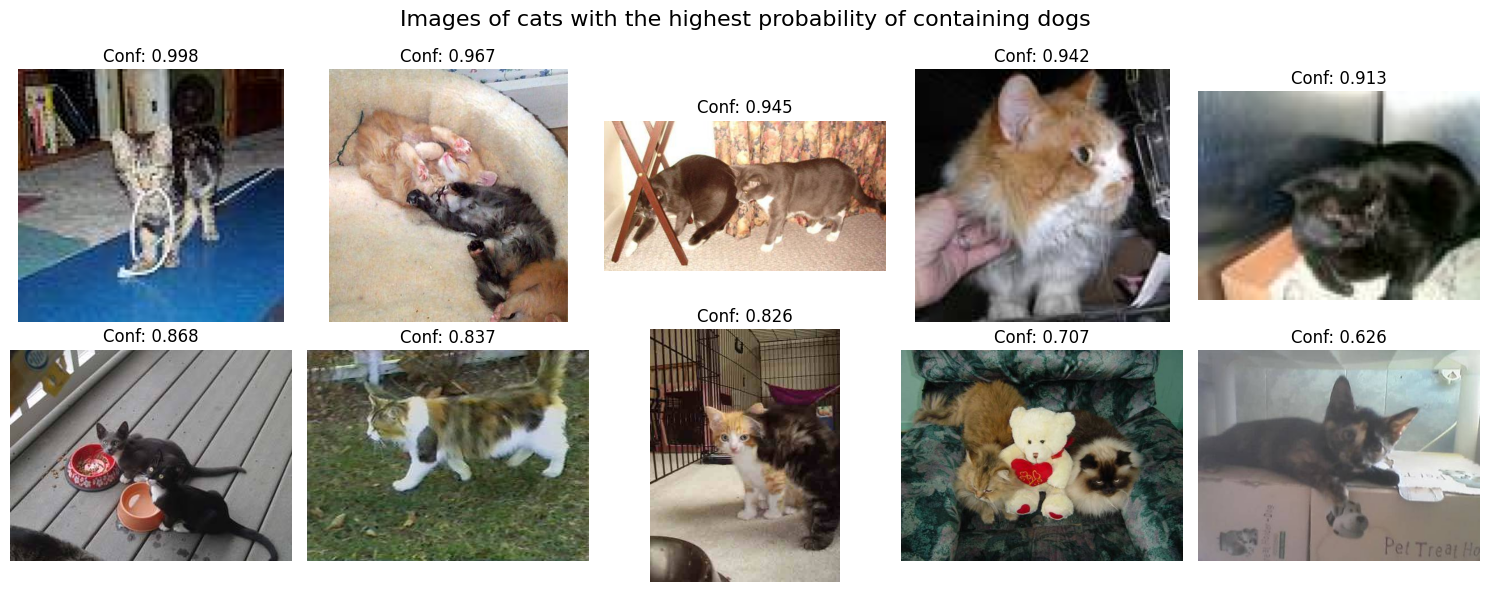

In [19]:
"""
Display the model's most confident misclassifications of cats as dogs.

Retrieves validation images that are actually cats but were incorrectly
predicted as dogs with high confidence. These false positives reveal
which cat features the model mistakes for dog characteristics.

Parameters used:
    get_highest_probability=True: Sort by confidence descending
    label=1: Dog class predictions
    number_of_items=10: Retrieve top 10 errors
    only_false_predictions=True: Only show misclassified images
"""

# Incorrect predictions of 'dog'
indices = get_images_with_sorted_probabilities(prediction_table,
                                              get_highest_probability=True, label=1, number_of_items=10,
                                              only_false_predictions=True)
message = 'Images of cats with the highest probability of containing dogs'
display(indices[:10], message)

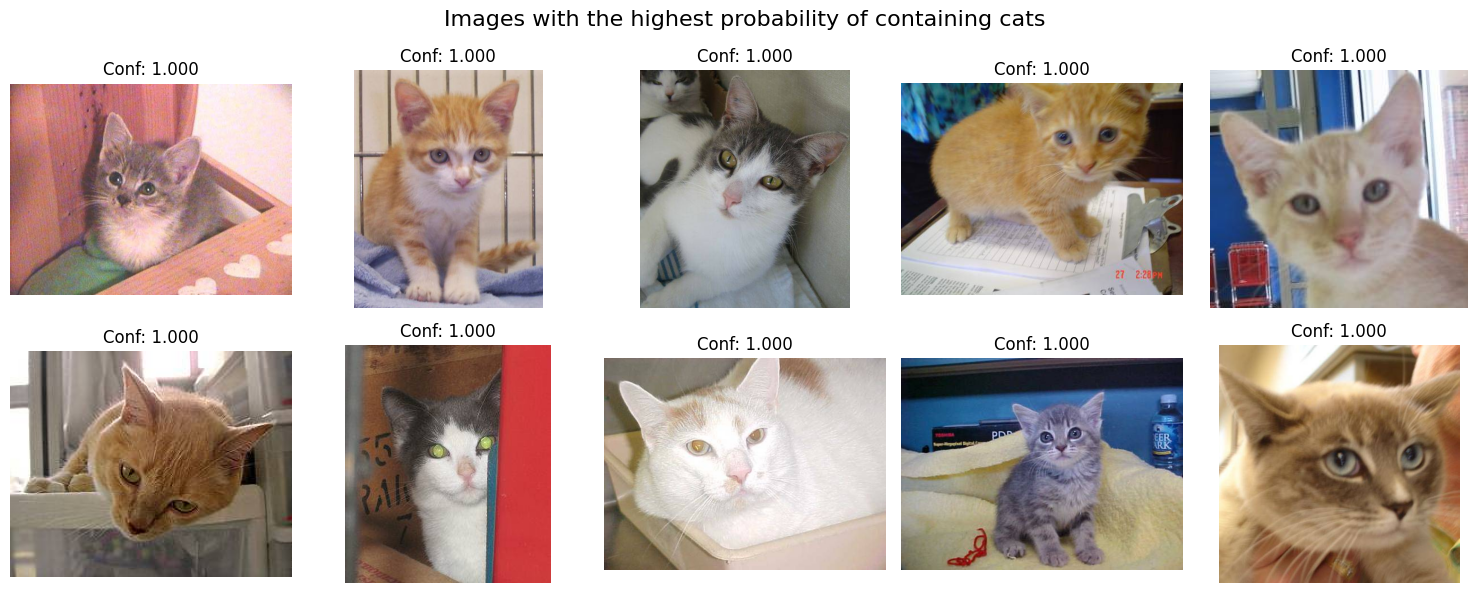

In [20]:
"""
Display the model's most confident cat predictions.

Retrieves and visualizes the 10 validation images that the model predicted
as 'cat' with the highest confidence scores, showing what features the model
strongly associates with cats.

Parameters used:
    get_highest_probability=True: Sort by confidence descending
    label=0: Cat class (assuming cats=0, dogs=1)
    number_of_items=10: Retrieve top 10 predictions
    only_false_predictions=False: Include both correct and incorrect predictions
"""

# Most confident predictions of 'cat'
indices = get_images_with_sorted_probabilities(prediction_table,
                                              get_highest_probability=True, label=0, number_of_items=10,
                                              only_false_predictions=False)
message = 'Images with the highest probability of containing cats'
display(indices[:10], message)

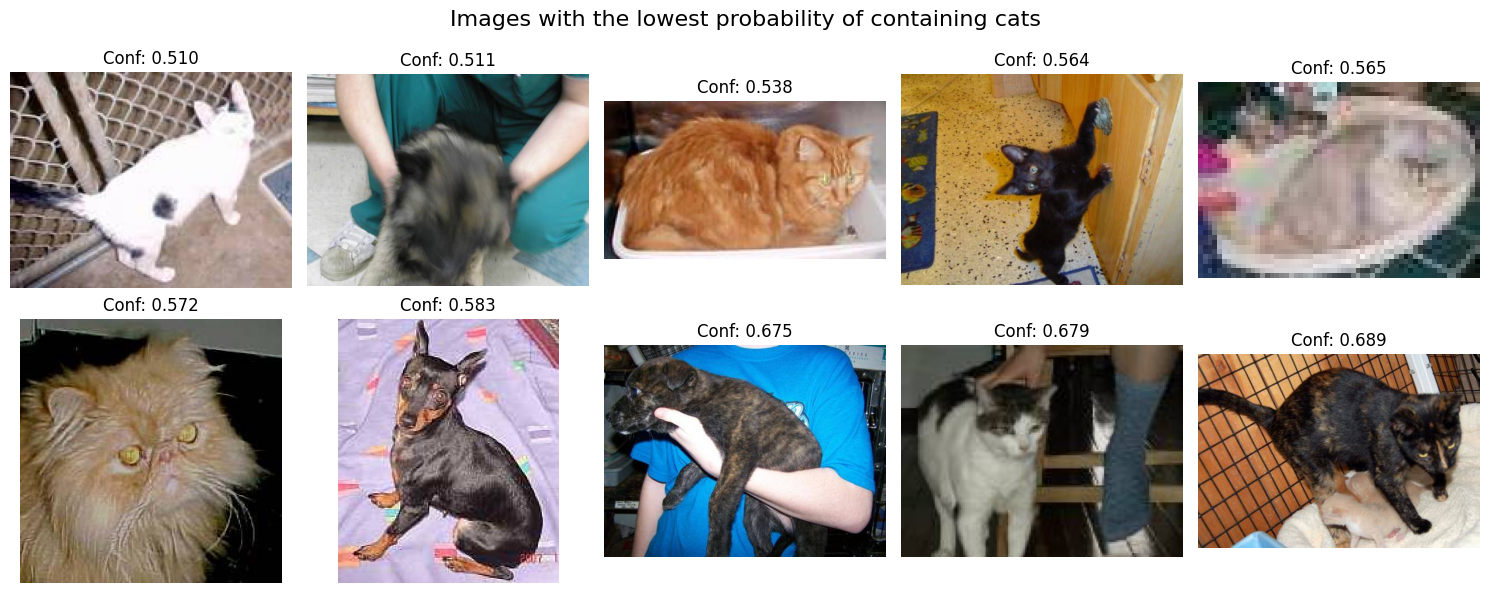

In [21]:
"""
Display the model's least confident cat predictions.

Retrieves and visualizes the 10 validation images that the model predicted
as 'cat' with the lowest confidence scores, revealing borderline cases
where the model barely chose 'cat' over 'dog'.

Parameters used:
    get_highest_probability=False: Sort by confidence ascending
    label=0: Cat class (assuming cats=0, dogs=1)
    number_of_items=10: Retrieve bottom 10 predictions
    only_false_predictions=False: Include both correct and incorrect predictions
"""

# Least confident predictions of 'cat'
indices = get_images_with_sorted_probabilities(prediction_table,
                                              get_highest_probability=False, label=0, number_of_items=10,
                                              only_false_predictions=False)
message = 'Images with the lowest probability of containing cats'
display(indices[:10], message)

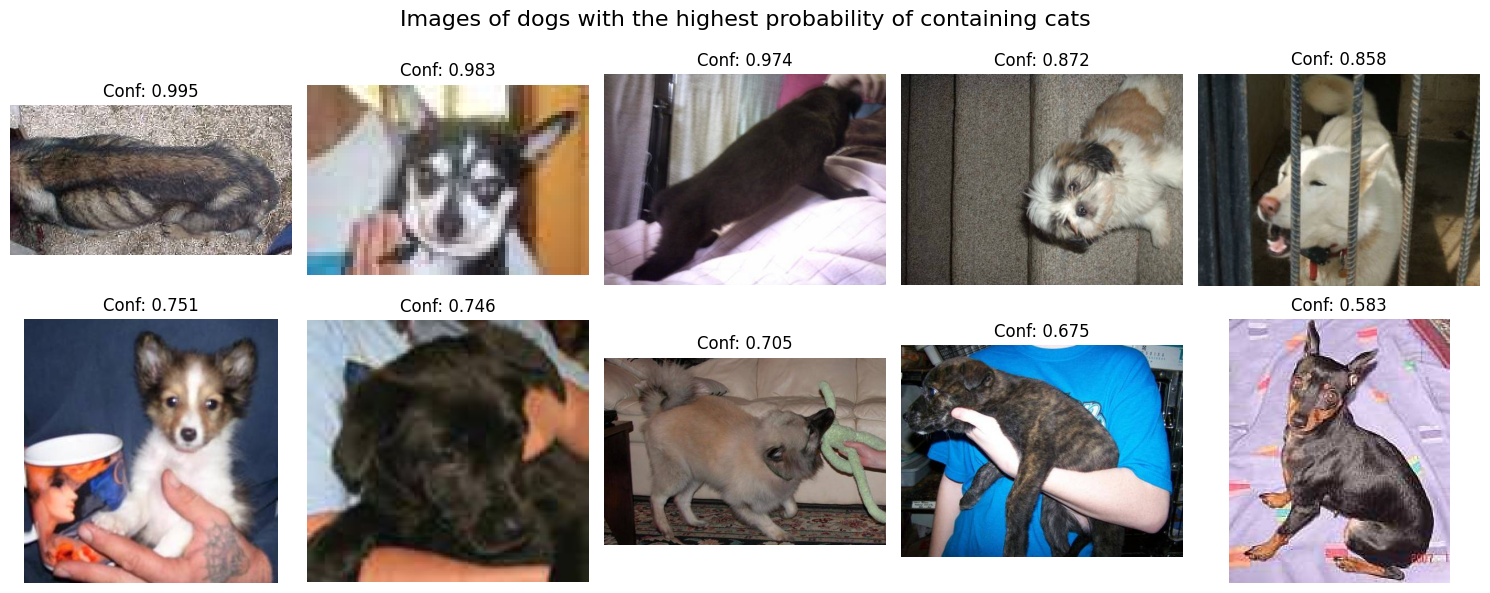

In [22]:
"""
Display the model's most confident misclassifications of dogs as cats.

Retrieves validation images that are actually dogs but were incorrectly
predicted as cats with high confidence. These false positives reveal
which dog features the model mistakes for cat characteristics.

Parameters used:
    get_highest_probability=True: Sort by confidence descending
    label=0: Cat class predictions
    number_of_items=10: Retrieve top 10 errors
    only_false_predictions=True: Only show misclassified images
"""

# Incorrect predictions of 'cat'
indices = get_images_with_sorted_probabilities(prediction_table,
                                              get_highest_probability=True, label=0, number_of_items=10,
                                              only_false_predictions=True)
message = 'Images of dogs with the highest probability of containing cats'
display(indices[:10], message)